In [141]:
'''
Experiment Design (Tensor Design)

- Ticks (BLK, CG, APO, KKR (Y), 'US10Y','WTI_Crude', SP500, NQ)
- News (BLK, CG, APO, KKR)
- 2 consecutive years
- Close/Polarity
- Ticks (All large cap US in fin serv, all PE, 5-8 indicators, News on all ticks, Open/Close/High/Low/MACD/EMA/CCR/Polarity)
- Tensor would be # Tickers X # days X # Values

- Ticks and News from Intrinio / Technicals from Alpha Vantage
'''

### Question for modeling purposes ###

### Input data
# How to shape the input data in terms of columns and rows?
# How to deal with missing days, holidays and weekends?
# Scale/normalize/one-hot-encode? How to treat number sequences, especially when prices / indices / percentage changes
# Prices need conversion to relative? Or need convert to 1 for increase or 0 for decrease?
# Input shape for wavelet? input shape for autoencoder? input shape for LSTM?
# Alternatives for wavelet--->make stationary?
# Split between train and validate? Scaling/Normalizing validate set?
# Outputs: how to read output? in terms of prob? in terms of change?
# Some plots for the tutorial: Sentiment vs Price? Price alone, Sentiment alone
# Wavelet decomposition plot
# auto encoder picture
# LSTM picture
# Final network



"\nExperiment Design (Tensor Design)\n\n- Ticks (BLK, CG, APO, KKR (Y), 'US10Y','WTI_Crude', SP500, NQ)\n- News (BLK, CG, APO, KKR)\n- 2 consecutive years\n- Close/Polarity\n- Ticks (All large cap US in fin serv, all PE, 5-8 indicators, News on all ticks, Open/Close/High/Low/MACD/EMA/CCR/Polarity)\n- Tensor would be # Tickers X # days X # Values\n\n- Ticks and News from Intrinio / Technicals from Alpha Vantage\n"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysentiment as pt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import pywt as pywt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import math

In [5]:
news = pd.read_csv('/Users/patrickbaginski/PycharmProjects/untitled/data/news.csv')
news = news.drop_duplicates('TITLE', keep=False)
news = news.drop(columns=['URL'])

In [6]:
lm = pt.LM()
news['SUMMARY_SCORES'] = news.SUMMARY.map(lambda x: lm.get_score(lm.tokenize(str(x))))
news['POLARITY'] = news['SUMMARY_SCORES'].map(lambda x: x['Polarity'])

In [7]:
news['PUBLICATION_DATE'] = pd.to_datetime(news['PUBLICATION_DATE'])
d = datetime.now()
only_date, only_time = d.date(), d.time()
news['DATE'] = [d.date() for d in news['PUBLICATION_DATE']]
news['DATE'] = pd.to_datetime(news['DATE'])
news_cleaned = news.groupby(['DATE','TICKER'], as_index=False).agg({'POLARITY':'sum'})

In [8]:
prices = pd.read_csv('/Users/patrickbaginski/PycharmProjects/untitled/data/prices.csv')
prices['DATE'] = pd.to_datetime(prices['DATE'])
prices['DATES'] = [d.date() for d in prices['DATE']]
prices['DATES'] = pd.to_datetime(prices['DATES'])
prices_clean = prices.drop(columns='DATE')

In [9]:
df = pd.merge(prices_clean, news_cleaned, left_on=['DATES','TICKER'], right_on=['DATE','TICKER'], how='left')
df = df.drop(columns=['DATE'])
df['POLARITY'] = df['POLARITY'].fillna(0)

In [12]:
### Let's look at the dates and values and see if there are any missing ones.

'''df.DATES.apply(lambda dt: dt.date()).groupby([df.TICKER, df.DATES.apply(lambda dt: dt.year)]).nunique()

df.groupby('TICKER')['CLOSE_PRICE','POLARITY'].agg('count')

df[df.isnull().any(axis=1)]'''


"df.DATES.apply(lambda dt: dt.date()).groupby([df.TICKER, df.DATES.apply(lambda dt: dt.year)]).nunique()\n\ndf.groupby('TICKER')['CLOSE_PRICE','POLARITY'].agg('count')\n\ndf[df.isnull().any(axis=1)]"

In [11]:
# Our check's show that there are 40 missing close prices mostly for the holidays for US10Y and WTI (dates that do not exist in our stock price time series). We can safely drop those as we do not posess them either for our prices, nor do the prices in after trading change much during a holiday.

df_a = df.loc[df['DATES'].isin(df['DATES'].where(df['TICKER']=='KKR'))]
df_b = df_a.loc[df['DATES'].isin(df['DATES'].where(df['DATES']<='2018-08-3'))]
df_b['CLOSE_PRICE'] = df_b['CLOSE_PRICE'].fillna(method='ffill')



/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [12]:
# Checking if the clean-up produced the desired result. Remaining question: US10 is yield in %, whereas rest is in USD. How to treat this?

df_clean = df_b
df_clean.groupby('TICKER')['CLOSE_PRICE','POLARITY'].agg('count')
df_clean.to_csv('/Users/patrickbaginski/PycharmProjects/untitled/data/df_clean.csv')



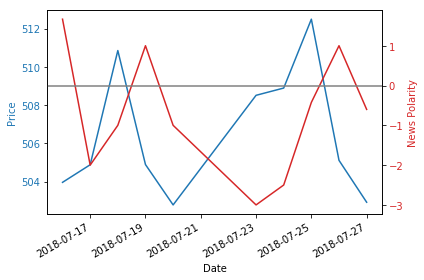

In [13]:
### Let's plot 2017 data to check for gaps
import matplotlib.dates as mdates
%matplotlib inline

blk = df_clean.loc[(df_clean['TICKER'] == 'BLK') & ((df_clean['DATES'] <= '2018-07-27') & (df_clean['DATES'] >='2018-07-16'))]

fig, ax1 = plt.subplots()

color_1 = 'tab:blue'
color_2 = 'tab:red'

ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color_1)
ax1.plot(blk['DATES'], blk['CLOSE_PRICE'], color=color_1)
ax1.tick_params(axis='y', labelcolor=color_1)

ax2 = ax1.twinx()

ax2.set_ylabel('News Polarity', color=color_2)
ax2.plot(blk['DATES'], blk['POLARITY'], color=color_2)
ax2.tick_params(axis='y', labelcolor=color_2)
ax2.axhline(y=0, color='grey')

plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
fig.tight_layout()

plt.show()
fig.savefig('fig1.png', dpi=300)

In [14]:
### Load the data, check for missing dates / We will ignore weekends and holidays, as prices (in after-trading) change only minimally.
# However, we need to make sure that we have all dates for the two years for each of the input tickers and indices.

# At this point, plot KKR price and polarity in comparison. Check for gaps in weekly data.

df_prices = df_clean.pivot(index='DATES', columns='TICKER', values='CLOSE_PRICE')
df_polarity = df_clean.pivot(index='DATES', columns='TICKER', values='POLARITY')

for i in df_polarity.columns:
    df_polarity.rename(columns={i: i+'_POL'}, inplace=True)

final = pd.concat([df_prices, df_polarity],  axis=1).drop(columns=['WTI_POL','US10_POL','SP500_POL','NQ_POL'])

final_label = final['KKR']




In [15]:
### Split into train and validate

feature_cols = ['KKR','APO','BLK','CG','NQ','SP500','US10','WTI','APO_POL','BLK_POL','CG_POL','KKR_POL']
label_col = ['KKR']

train = final[:400]
validate = final[400:]

In [18]:
### Normalizing features
train_data = train[feature_cols].as_matrix().astype(np.float)
validate_data = validate[feature_cols].as_matrix().astype(np.float)

scaler = MinMaxScaler()

smoothing_window_size = 60

for d in range(0,360,smoothing_window_size):
    scaler.fit(train_data[d:d+smoothing_window_size,:])
    train_data[d:d+smoothing_window_size,:] = scaler.transform(train_data[d:d+smoothing_window_size,:])
    
scaler.fit(train_data[d+smoothing_window_size:,:])
train_data[d+smoothing_window_size:,:] = scaler.transform(train_data[d+smoothing_window_size:,:])
norm_validate = scaler.transform(validate_data)

train_norm = train_data
validate_norm = norm_validate

train = final[:400]
validate = final[400:]

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
time_steps = 3

x = train_norm[:,1:]
y = train_norm[:,0]
norm_train_denoised = []
dwt = np.zeros((len(x), x.shape[1]))

z = validate_norm[:,1:]
w = validate_norm[:,0]
norm_val = []
z_trans = np.zeros((len(z), z.shape[1]))

for i in range(x.shape[1]):
    (ca, cd) = pywt.dwt(x[:,i], 'haar')
    cat = pywt.threshold(ca, np.std(ca)/2, mode='soft')
    cdt = pywt.threshold(cd, np.std(cd)/2, mode='soft')
    dwt[:,i] = pywt.idwt(cat, cdt, 'haar')
    z_trans[:,i] = z[:,i]

for i in range(len(dwt)-time_steps-1):
    x_temp = dwt[i:(i+time_steps),:]
    y_temp = y[i+time_steps+1]
    norm_train_denoised.append([x_temp, y_temp])
    
for i in range(len(z_trans)-time_steps-1):
    z_temp = z_trans[i:(i+time_steps),:]
    w_temp = w[i+time_steps+1]
    norm_val.append([z_temp,w_temp])

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


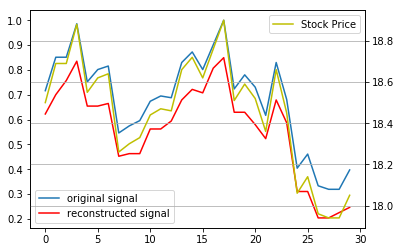

In [20]:
### Smoothing of the data using discrete wavelet transformation
plt.close('all')

fig, ax1 = plt.subplots()

plt.plot(x[0:30,0])
plt.plot(dwt[0:30,0], 'r')
plt.legend(['original signal', 'reconstructed signal'])

ax2 = ax1.twinx()
plt.plot(train[feature_cols].as_matrix().astype(np.float)[0:30,1], 'y')

plt.legend(['Stock Price'])
plt.grid('on')
plt.show()
fig.savefig('fig2.png', dpi=300)

In [21]:
### Flattening out the training and validation set for the autoencoder
train_ae = np.concatenate([d[0] for d in norm_train_denoised], axis=0)
val_ae = np.concatenate([d[0] for d in norm_val], axis=0)

In [33]:
### Applying neural autoencoder network to smooth the time series - Architecture
# Defining the nodes per layer
n_nodes_enc = int(train_ae.shape[1])
n_nodes_hid_enc = 10
n_nodes_hid_dec = 10
n_nodes_dec = int(train_ae.shape[1])

# Randomisingly assigning values for biases and weights in the layers
hid_1_vals = {
    'weights':tf.Variable(tf.random_normal([n_nodes_enc,n_nodes_hid_enc])),
    'biases':tf.Variable(tf.random_normal([n_nodes_hid_enc]))}

hid_2_vals = {
    'weights':tf.Variable(tf.random_normal([n_nodes_hid_enc, n_nodes_hid_dec])),
    'biases':tf.Variable(tf.random_normal([n_nodes_hid_dec]))}

output_layer_vals = {
    'weights':tf.Variable(tf.random_normal([n_nodes_hid_dec,n_nodes_dec])),
    'biases':tf.Variable(tf.random_normal([n_nodes_dec]))}

# Building the architecture for the neural net
input_layer = tf.placeholder('float', [None, 11])

layer_1 = tf.nn.sigmoid(
    tf.add(tf.matmul(input_layer,hid_1_vals['weights']),
           hid_1_vals['biases']))

layer_2 = tf.nn.sigmoid(
    tf.add(tf.matmul(layer_1,hid_2_vals['weights']),
           hid_2_vals['biases']))

output_layer = tf.matmul(layer_2,output_layer_vals['weights']) + output_layer_vals['biases']

norm_denoised_signal_orig = tf.placeholder('float', [None, 11])

meansq = tf.reduce_mean(tf.square(output_layer - norm_denoised_signal_orig))

learn_rate = 0.01
optimizer = tf.train.AdagradOptimizer(learn_rate).minimize(meansq)

In [43]:
### Initializing autoencoder to smooth time series

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch_size = 30
n_epochs = 1000
tot_size = 1188

for epoch in range(n_epochs):
    epoch_loss = 0
    
    for i in range(int(tot_size//batch_size)):
        epoch_x = train_ae[i*batch_size:(i+1)*batch_size]
        
        _, c = sess.run([optimizer, meansq],feed_dict={input_layer: epoch_x,norm_denoised_signal_orig:epoch_x})
        epoch_loss += c
        
print('Epoch', epoch, n_epochs, 'loss:', epoch_loss)


('Epoch', 999, 1000, 'loss:', 1.295825312845409)


In [44]:
train_encoded = sess.run(output_layer, feed_dict={input_layer: train_ae})
train_lstm = train_encoded.reshape((int(len(train_encoded)/time_steps), time_steps, train_norm.shape[1]-1))

val_encoded = sess.run(output_layer, feed_dict={input_layer: val_ae})
val_lstm = val_encoded.reshape((int(len(val_encoded)/time_steps), time_steps, validate_norm.shape[1]-1))


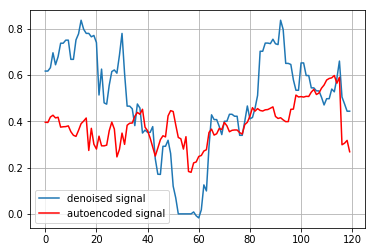

In [46]:
### Plotting a brief comparison

plt.close('all')

fig, ax1 = plt.subplots()

plt.plot(dwt[0:120,1])
plt.plot(train_lstm[4:124,0,1], 'r')
plt.legend(['denoised signal', 'autoencoded signal'])
plt.grid('on')
plt.show()
fig.savefig('fig3.png', dpi=300)

In [47]:
### Appening the KKR stock price back to the set
data_train = [[x, y[1]] for (x,y) in zip(train_lstm, norm_train_denoised)]
data_val = [[x, y[1]] for (x,y) in zip(val_lstm, norm_val)]

In [48]:
### Splitting up features and predictor variable

train_x = np.array([x[0] for x in data_train])
train_y = np.array([y[1] for y in data_train])
val_x = np.array([x[0] for x in data_val])
val_y = np.array([y[1] for y in data_val])
print(train_x.shape, train_y.shape, val_x.shape, val_y.shape)

((396, 3, 11), (396,), (96, 3, 11), (96,))


In [49]:
### Building the model architecture
model = Sequential()
model.add(LSTM(100, input_shape=(time_steps, 11)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs = 100, batch_size = 30, verbose = 2)

Epoch 1/100


 - 2s - loss: 0.1170


Epoch 2/100
 - 0s - loss: 0.0620


Epoch 3/100


 - 0s - loss: 0.0524


Epoch 4/100


 - 0s - loss: 0.0489


Epoch 5/100


 - 0s - loss: 0.0490


Epoch 6/100


 - 0s - loss: 0.0471


Epoch 7/100


 - 0s - loss: 0.0464


Epoch 8/100


 - 0s - loss: 0.0462


Epoch 9/100


 - 0s - loss: 0.0457


Epoch 10/100


 - 0s - loss: 0.0455


Epoch 11/100


 - 0s - loss: 0.0449


Epoch 12/100


 - 0s - loss: 0.0451


Epoch 13/100


 - 0s - loss: 0.0448


Epoch 14/100


 - 0s - loss: 0.0440


Epoch 15/100


 - 0s - loss: 0.0431


Epoch 16/100


 - 0s - loss: 0.0425


Epoch 17/100


 - 0s - loss: 0.0422


Epoch 18/100


 - 0s - loss: 0.0418


Epoch 19/100


 - 0s - loss: 0.0423


Epoch 20/100


 - 0s - loss: 0.0406


Epoch 21/100


 - 0s - loss: 0.0430


Epoch 22/100


 - 0s - loss: 0.0407


Epoch 23/100


 - 0s - loss: 0.0416


Epoch 24/100


 - 0s - loss: 0.0392


Epoch 25/100


 - 0s - loss: 0.0388


Epoch 26/100


 - 0s - loss: 0.0388


Epoch 27/100


 - 0s - loss: 0.0394


Epoch 28/100


 - 0s - loss: 0.0396


Epoch 29/100


 - 0s - loss: 0.0383


Epoch 30/100


 - 0s - loss: 0.0378


Epoch 31/100


 - 0s - loss: 0.0382


Epoch 32/100


 - 0s - loss: 0.0391


Epoch 33/100


 - 0s - loss: 0.0375


Epoch 34/100


 - 0s - loss: 0.0367


Epoch 35/100


 - 0s - loss: 0.0368


Epoch 36/100


 - 0s - loss: 0.0365


Epoch 37/100


 - 0s - loss: 0.0365


Epoch 38/100


 - 0s - loss: 0.0385


Epoch 39/100


 - 0s - loss: 0.0370


Epoch 40/100


 - 0s - loss: 0.0384


Epoch 41/100


 - 0s - loss: 0.0384


Epoch 42/100


 - 0s - loss: 0.0366


Epoch 43/100


 - 0s - loss: 0.0376


Epoch 44/100


 - 0s - loss: 0.0400


Epoch 45/100


 - 0s - loss: 0.0365


Epoch 46/100


 - 0s - loss: 0.0352


Epoch 47/100


 - 0s - loss: 0.0375


Epoch 48/100


 - 0s - loss: 0.0354


Epoch 49/100


 - 0s - loss: 0.0366


Epoch 50/100


 - 0s - loss: 0.0349


Epoch 51/100


 - 0s - loss: 0.0350


Epoch 52/100


 - 0s - loss: 0.0351


Epoch 53/100


 - 0s - loss: 0.0344


Epoch 54/100


 - 0s - loss: 0.0342


Epoch 55/100


 - 0s - loss: 0.0357


Epoch 56/100


 - 0s - loss: 0.0366


Epoch 57/100


 - 0s - loss: 0.0343


Epoch 58/100


 - 0s - loss: 0.0354


Epoch 59/100


 - 0s - loss: 0.0354


Epoch 60/100


 - 0s - loss: 0.0334


Epoch 61/100


 - 0s - loss: 0.0344


Epoch 62/100


 - 0s - loss: 0.0340


Epoch 63/100


 - 0s - loss: 0.0358


Epoch 64/100


 - 0s - loss: 0.0330


Epoch 65/100


 - 0s - loss: 0.0340


Epoch 66/100


 - 0s - loss: 0.0335


Epoch 67/100


 - 0s - loss: 0.0341


Epoch 68/100


 - 0s - loss: 0.0338


Epoch 69/100


 - 0s - loss: 0.0328


Epoch 70/100


 - 0s - loss: 0.0342


Epoch 71/100


 - 0s - loss: 0.0333


Epoch 72/100


 - 0s - loss: 0.0325


Epoch 73/100


 - 0s - loss: 0.0323


Epoch 74/100


 - 0s - loss: 0.0328


Epoch 75/100


 - 0s - loss: 0.0326


Epoch 76/100


 - 0s - loss: 0.0325


Epoch 77/100


 - 0s - loss: 0.0326


Epoch 78/100


 - 0s - loss: 0.0316


Epoch 79/100


 - 0s - loss: 0.0317


Epoch 80/100


 - 0s - loss: 0.0328


Epoch 81/100


 - 0s - loss: 0.0337


Epoch 82/100


 - 0s - loss: 0.0324


Epoch 83/100


 - 0s - loss: 0.0319


Epoch 84/100


 - 0s - loss: 0.0322


Epoch 85/100


 - 0s - loss: 0.0323


Epoch 86/100


 - 0s - loss: 0.0312


Epoch 87/100


 - 0s - loss: 0.0307


Epoch 88/100


 - 0s - loss: 0.0304


Epoch 89/100


 - 0s - loss: 0.0309


Epoch 90/100


 - 0s - loss: 0.0321


Epoch 91/100


 - 0s - loss: 0.0368


Epoch 92/100


 - 0s - loss: 0.0319


Epoch 93/100


 - 0s - loss: 0.0330


Epoch 94/100


 - 0s - loss: 0.0352


Epoch 95/100


 - 0s - loss: 0.0350


Epoch 96/100


 - 0s - loss: 0.0324


Epoch 97/100


 - 0s - loss: 0.0315


Epoch 98/100


 - 0s - loss: 0.0299


Epoch 99/100


 - 0s - loss: 0.0301


Epoch 100/100


 - 0s - loss: 0.0300


In [64]:
### Building the LSTM network

train_preds = model.predict(train_x)
val_preds = model.predict(val_x)

# train_preds_inv = scaler.inverse_transform(train_preds)
# train_y_inv = scaler.inverse_transform([train_y])
# val_preds_inv = scaler.inverse_transform([val_preds])

train_score = math.sqrt(mean_squared_error(train_y, train_preds))
print('Train score: %.2f RMSE' % (train_score))
val_score = math.sqrt(mean_squared_error(val_y, val_preds))
print('Validation score: %.2f RMSE' % (val_score))

Train score: 0.17 RMSE
Validation score: 0.73 RMSE


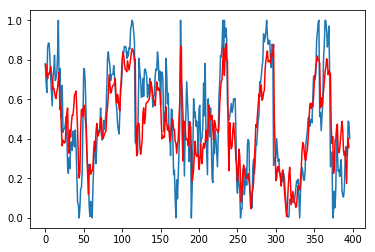

In [103]:
plt.plot(train_norm[3:,0])
plt.plot(train_preds, 'r')
fig.savefig('fig4.png', dpi=300)

plt.show()